In [46]:
run_id = 'hard-hat_1549667969_34884894' 
run = Run(experiment=experiment, run_id=run_id)


## Workplace safety with Azure Machine Learning
<img align="left" src="./resources/end2end.png" width=800x />

## Import open source Python libraries

In [26]:
import requests
import utils
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import environment_definition

## Import Azure Machine Learning Python SDK

In [42]:
from azureml.core import Workspace, Experiment
from azureml.core.model import Model
from azureml.core.run import Run
from azureml.widgets import RunDetails
from azureml.core.image import ContainerImage
from azureml.train.dnn import TensorFlow
from azureml.core.runconfig import AzureContainerRegistry, DockerEnvironment, EnvironmentDefinition, PythonEnvironment

from azureml.core.compute import AksCompute, ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.webservice import Webservice, AksWebservice

from azureml.core.image import Image
from azureml.contrib.iot import IotContainerImage

## Connect to Azure Machine Learning workspace
An Azure Machine Learning workspace is logically a container that has everything your team needs for machine learning
<img align="left" src="./resources/workspace.png" width=800x />

In [20]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')


Found the config file in: c:\demo\ready\readydemo\config.json
contosomanufacturing
scottgu-all-hands
eastus2
2a779d6f-0806-4359-a6e8-f1fd57bb5dd7


## Collect and prepare training data

<HTML>
    <TR>
        <TD><img src="./images/IMG_1143.jpg" /></TD>
        <TD><img src="./images/IMG_1195.jpg" /></TD>
        <TD><img src="./images/IMG_1169.jpg" /></TD>
        <TD><img src="./images/IMG_1172.jpg" /></TD>
    </TR>
    <TR>
        <TD><img src="./images/IMG_1148.jpg" /></TD>
        <TD><img src="./images/IMG_1183.jpg" /></TD>
        <TD><img src="./images/IMG_1171.jpg" /></TD>
        <TD><img src="./images/IMG_1152.jpg" /></TD>
    </TR>
</HTML>

## Create Azure Machine Learning experiment

In [52]:
experiment_name = 'hard-hat'
experiment = Experiment(workspace=ws, name=experiment_name)

## Create auto-scaling AML Compute GPU cluster

In [16]:
# Choose a name for your GPU cluster
cluster_name = "gpucluster"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace = ws, name = cluster_name)
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           min_nodes=0,
                                                           max_nodes=4)
    gpu_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

gpu_cluster.wait_for_completion(show_output=True)

Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


<img align="left" src="./resources/compute.png" width=800x />

## Upload training data to Azure Machine Learning Data Store

In [17]:
# Prepare data
ds = ws.get_default_datastore()
ds.upload('./data')

$AZUREML_DATAREFERENCE_workspaceblobstore

## Use prebuilt or your own custom docker container to train model for repeatability

In [41]:
env_def = EnvironmentDefinition()
env_def.docker = environment_definition.docker_config
env_def.python = environment_definition.python_config

print('Base docker image: ' + env_def.docker.base_image)
print('GPU Enabled: ' + str(env_def.docker.gpu_support))

Base docker image: contosoml/base-gpu:0.2.1
GPU Enabled: True


## Train model using TensorFlow estimator on the AMLCompute GPU cluster

In [ ]:
script_params = {
    '--model_dir': './outputs',
    '--pipeline_config_path': './faster_rcnn_resnet101_hardhats.config'
}

tf_est = TensorFlow(source_directory = './src',
                    script_params=script_params,
                    compute_target=gpu_cluster,
                    entry_script='train.py',
                    inputs=[ds.as_download(path_on_compute='/data')],
                    environment_definition=env_def)
run = experiment.submit(tf_est)

In [47]:
RunDetails(run).show() 

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

## Register model to track lineage, enable discoverability & reuse

In [ ]:
# register the model for deployment
model = Model.register(model_path = "../models/frozen_inference_graph.pb",
                       model_name = "frozen_inference_graph.pb",
                       description = "Contoso Manufacturing model",
                       workspace = ws)

In [ ]:
# Create a container image

model = Model.list(ws, name='frozen_inference_graph.pb')[0]

image_config = ContainerImage.image_configuration(execution_script='score.py',
                                                  runtime='python',
                                                  conda_file='score.yml',
                                                  description='Object detection model')

image = ContainerImage.create(name='contosoimage',
                              models=[model],
                              image_config=image_config,
                              workspace=ws)


## Create Azure Kubernetes Cluster

In [ ]:
# Create an AKS cluster

aks_cluster_name = 'contoso-aks'

# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration(location='eastus2')

# Create the cluster
aks_target = ComputeTarget.create(workspace=ws, 
                                  name=aks_cluster_name, 
                                  provisioning_configuration=prov_config)

aks_target.wait_for_completion(True)


In [ ]:
# Deploy the model as a service

aks_service_name = 'contosoman'
aks_config = AksWebservice.deploy_configuration(collect_model_data=True, enable_app_insights=True)
aks_service = Webservice.deploy_from_image(workspace=ws, 
                                           name=aks_service_name,
                                           image=image,
                                           deployment_config=aks_config,
                                           deployment_target=aks_target)
aks_service


# Test the service

In [50]:
# Test the service
test_image = './score/samples/Before.jpg'
image = open(test_image, 'rb')
input_data = image.read()
image.close()

aks_service_name = 'contosoman2'
aks_service = AksWebservice(workspace=ws, name=aks_service_name)

auth = 'Bearer ' + aks_service.get_keys()[0]
uri = aks_service.scoring_uri

res = requests.post(url=uri,
                    data=input_data,
                    headers={'Authorization': auth, 'Content-Type': 'application/octet-stream'})

results = res.json()

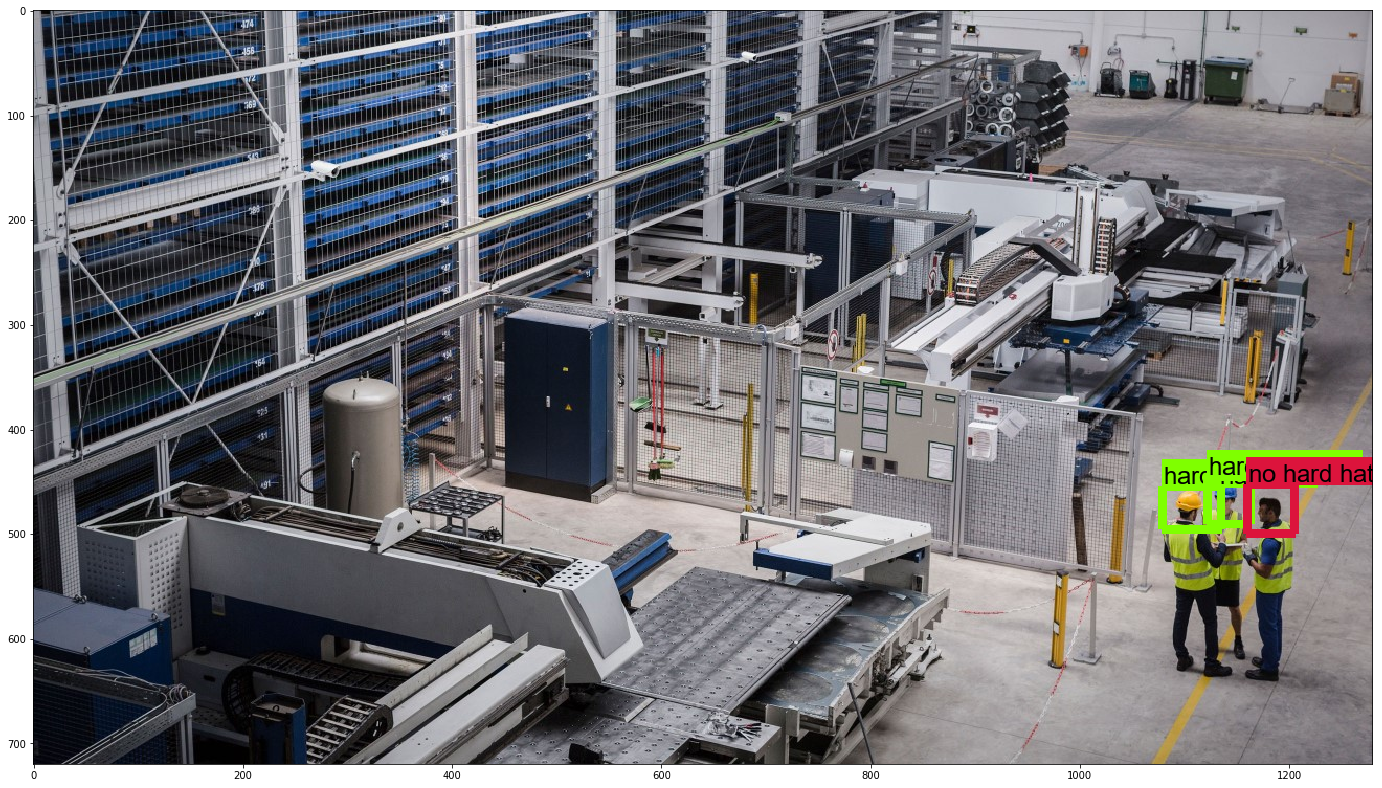

In [53]:
# Show the results
image = Image.open(test_image)
image_np = utils.load_image_into_numpy_array(image)
category_index = utils.create_category_index_from_labelmap('./score/samples/label_map.pbtxt', use_display_name=True)

utils.visualize_boxes_and_labels_on_image_array(
    image_np,
    np.array(results['detection_boxes']),
    np.array(results['detection_classes']),
    np.array(results['detection_scores']),
    category_index,
    instance_masks=results.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)

plt.figure(figsize=(24, 16))
plt.imshow(image_np)

# Create Docker image optimized for the edge

In [ ]:
# Build container image

image_config = IotContainerImage.image_configuration(
                                 architecture='arm32v7',
                                 execution_script='main.py',
                                 dependencies=['camera.py','iot.py','ipcprovider.py','utility.py','frame_iterators.py'],
                                 docker_file='Dockerfile',
                                 description='Object detection model (Edge)')

image = Image.create(name = 'contosoimage-edge',
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)